In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google import genai
import os
import time
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import json
import logging
import warnings
warnings.filterwarnings('ignore')

os.environ["GEMINI_API_KEY"] = "api_key"

CLIENT = genai.Client(
    api_key=os.getenv("GEMINI_API_KEY")
)

In [2]:
df = pd.read_csv('yelp.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [3]:
for col in df.columns:
    print(f"Unique values in {col}: {df[col].nunique()}")

Unique values in business_id: 4174
Unique values in date: 1995
Unique values in review_id: 10000
Unique values in stars: 5
Unique values in text: 9998
Unique values in type: 1
Unique values in user_id: 6403
Unique values in cool: 29
Unique values in useful: 28
Unique values in funny: 29


In [4]:
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


Rating distribution:
stars
1     749
2     927
3    1461
4    3526
5    3337
Name: count, dtype: int64

Percentages:
stars
1     7.49
2     9.27
3    14.61
4    35.26
5    33.37
Name: proportion, dtype: float64


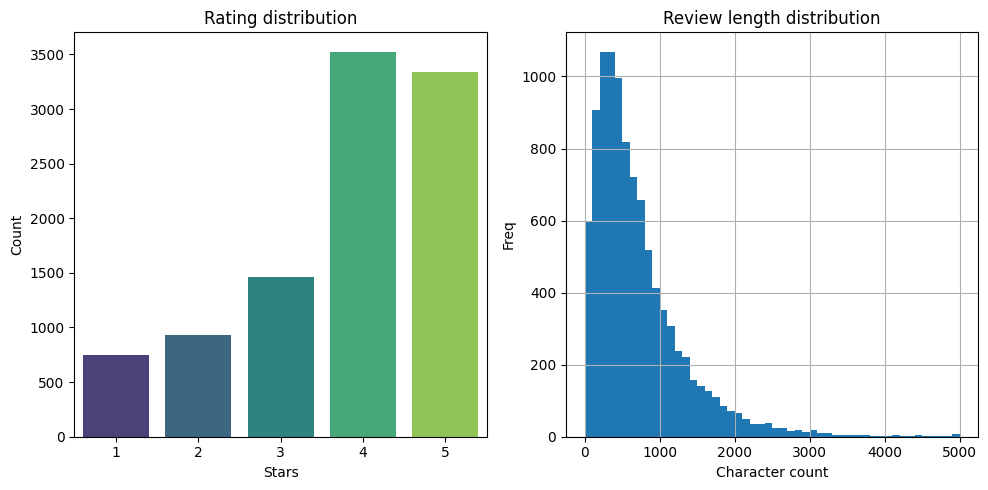

In [5]:
# Check the distribution of ratings
rating_dist = df['stars'].value_counts().sort_index()
print("Rating distribution:")
print(rating_dist)
print(f"\nPercentages:")
print(df['stars'].value_counts(normalize=True).sort_index() * 100)

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='stars', palette='viridis')
plt.title('Rating distribution')
plt.xlabel('Stars')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['text'].str.len().hist(bins=50)
plt.title('Review length distribution')
plt.xlabel('Character count')
plt.ylabel('Freq')
plt.tight_layout()
plt.show()

In [6]:
# we are sampling 40 reviews from each star rating for a BALANCED sample test dataset of 200 reviews

np.random.seed(42)

test_df = []
for i in df['stars'].unique():
    ratings = df[df['stars'] == i]
    test_df.append(ratings.sample(40, random_state=42)) # There are more than 40 reviews for each rating so no need for edge case handling

In [7]:
test_df = pd.concat(test_df, ignore_index=True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  200 non-null    object
 1   date         200 non-null    object
 2   review_id    200 non-null    object
 3   stars        200 non-null    int64 
 4   text         200 non-null    object
 5   type         200 non-null    object
 6   user_id      200 non-null    object
 7   cool         200 non-null    int64 
 8   useful       200 non-null    int64 
 9   funny        200 non-null    int64 
dtypes: int64(4), object(6)
memory usage: 15.8+ KB


In [8]:
test_df['stars'].value_counts()

stars
5    40
4    40
2    40
3    40
1    40
Name: count, dtype: int64

In [9]:

def get_prompt_zero_shot(review_text):
    prompt = f"""You are a review rating classifier. Analyze the following customer review and predict the star rating from 1 to 5.

Review: "{review_text}"

Respond ONLY with valid JSON in this exact format (no additional text):
{{
  "predicted_stars": <number between 1-5>,
  "explanation": "<brief reasoning in one sentence>"
}}"""
    return prompt


def get_prompt_few_shot(review_text):
    prompt = f"""You are a review rating classifier. Here are examples of reviews and their ratings:

Example 1:
Review: "Absolutely terrible! Worst experience ever. Food was cold, service was rude, and the place was dirty. Never going back!"
Rating: 1 star (Very negative experience with multiple complaints)

Example 2:
Review: "Pretty disappointing. Expected much better. Food was mediocre and overpriced. Service was slow."
Rating: 2 stars (Negative experience with some specifics)

Example 3:
Review: "It's okay, nothing special. Food was average, service was decent. Wouldn't go out of my way to come here."
Rating: 3 stars (Neutral experience, neither good nor bad)

Example 4:
Review: "Really good! Enjoyed the food and the atmosphere. Service was friendly. Would recommend to friends."
Rating: 4 stars (Positive experience with good aspects)

Example 5:
Review: "Amazing experience! Best meal I've had in years! Exceptional service, perfect ambiance, incredible flavors. Can't wait to come back!"
Rating: 5 stars (Highly positive with enthusiasm)

Now classify this review:
Review: "{review_text}"

Respond ONLY with valid JSON in this exact format (no additional text):
{{
  "predicted_stars": <number between 1-5>,
  "explanation": "<brief reasoning in one sentence>"
}}"""
    return prompt


def get_prompt_chain_of_thought(review_text):
    prompt = f"""You are a review rating classifier. Analyze the following review step-by-step before predicting the rating.

Review: "{review_text}"

Think through the following aspects:
1. Overall Sentiment: Is it positive, negative, or neutral?
2. Specific Mentions: What aspects are mentioned (food, service, price, ambiance, etc.)?
3. Language Intensity: Are there strong words (amazing, terrible) or mild words (okay, decent)?
4. Complaints vs Praise: Does the review have more complaints or praise?
5. Likelihood to Return: Does the reviewer seem likely to return or recommend?

Based on your analysis:
- 1 star = Very negative, multiple complaints, strong negative language
- 2 stars = Mostly negative, some disappointment
- 3 stars = Neutral, mixed feelings, "okay" experience
- 4 stars = Mostly positive, good experience with minor issues
- 5 stars = Very positive, exceptional experience, high enthusiasm

Respond ONLY with valid JSON in this exact format (no additional text):
{{
  "predicted_stars": <number between 1-5>,
  "explanation": "<brief reasoning based on your analysis>"
}}"""
    return prompt


In [10]:
def get_llm_response(prompt, max_retries=3):

    # to disable warning
    genai.types.logging.disable(level=50)
    
    for attempt in range(max_retries):
        try:
            response = CLIENT.models.generate_content(model='gemini-3-flash-preview', contents=[prompt], config={'temperature':0.1})
            return response.text
        except Exception as e:
            print(f"⚠️ Attempt {attempt + 1} failed: {str(e)}")
            if attempt < max_retries - 1:
                time.sleep(2)  # Wait before retry
            else:
                return None
    return None


def parse_json_response(response_text):
    if not response_text:
        return None
    
    try:
        # Try direct parsing
        json_obj = json.loads(response_text)
        return json_obj
    except json.JSONDecodeError:
        # Try to extract JSON from markdown code blocks
        if "```json" in response_text:
            json_str = response_text.split("```json")[1].split("```")[0].strip()
            try:
                return json.loads(json_str)
            except:
                pass
        
        # Try to extract JSON between curly braces
        import re
        json_match = re.search(r'\{[^{}]*\}', response_text)
        if json_match:
            try:
                return json.loads(json_match.group())
            except:
                pass
    
    return None

In [11]:
def evaluate_approach(df_test, prompt_function, approach_name):
    """
    Evaluate a single prompting approach on the test dataset
    
    Args:
        df_test: DataFrame with reviews
        prompt_function: Function that generates prompts
        approach_name: Name of the approach for logging
    
    Returns:
        DataFrame with results
    """
    results = []
    valid_json_count = 0
    api_failure_count = 0
    
    print(f"\n{'='*60}")
    print(f"Running {approach_name}...")
    print(f"{'='*60}\n")
    
    for idx, row in df_test.iterrows():
        actual_rating = row['stars']
        review_text = row['text']
        
        prompt = prompt_function(review_text)
        response_text = get_llm_response(prompt)

        parsed_json = parse_json_response(response_text)
        
        # Extract prediction
        if parsed_json and 'predicted_stars' in parsed_json:
            predicted_rating = parsed_json['predicted_stars']
            explanation = parsed_json.get('explanation', 'N/A')
            is_valid_json = True
            valid_json_count += 1
        else:
            predicted_rating = None
            explanation = 'Failed to parse'
            is_valid_json = False
            if response_text is None:
                api_failure_count += 1
        
        results.append({
            'review_text': review_text[:100] + '...',  # Truncate for display
            'actual_stars': actual_rating,
            'predicted_stars': predicted_rating,
            'explanation': explanation,
            'is_valid_json': is_valid_json,
            'raw_response': response_text[:200] if response_text else 'API Failed'
        })
        
        if (idx + 1) % 20 == 0:
            print(f"Processed {idx + 1}/{len(df_test)} reviews...")
            time.sleep(1)  # Rate limiting
    
    results_df = pd.DataFrame(results)
    
    json_validity_rate = (valid_json_count / len(df_test)) * 100
    valid_predictions = results_df[results_df['predicted_stars'].notna()]
    if len(valid_predictions) > 0:
        accuracy = accuracy_score(
            valid_predictions['actual_stars'], 
            valid_predictions['predicted_stars']
        ) * 100
    else:
        accuracy = 0
    
    print(f"\n{'='*60}")
    print(f"{approach_name} - Results Summary")
    print(f"{'='*60}")
    print(f"Valid JSON Responses: {valid_json_count}/{len(df_test)} ({json_validity_rate:.2f}%)")
    print(f"API Failures: {api_failure_count}/{len(df_test)}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"{'='*60}\n")
    
    return results_df, {
        'approach': approach_name,
        'accuracy': accuracy,
        'json_validity': json_validity_rate,
        'total_samples': len(df_test),
        'valid_predictions': len(valid_predictions),
        'api_failures': api_failure_count
    }

In [12]:
# Store all results
all_results = {}
all_metrics = []

# Approach 1: Zero-Shot
results_zero_shot, metrics_zero_shot = evaluate_approach(
    test_df, 
    get_prompt_zero_shot, 
    "Approach 1: Zero-Shot Direct"
)
all_results['zero_shot'] = results_zero_shot
all_metrics.append(metrics_zero_shot)

# Small delay between approaches
time.sleep(5)

# Approach 2: Few-Shot
results_few_shot, metrics_few_shot = evaluate_approach(
    test_df, 
    get_prompt_few_shot, 
    "Approach 2: Few-Shot with Examples"
)
all_results['few_shot'] = results_few_shot
all_metrics.append(metrics_few_shot)

# Small delay
time.sleep(5)

# Approach 3: Chain-of-Thought
results_cot, metrics_cot = evaluate_approach(
    test_df, 
    get_prompt_chain_of_thought, 
    "Approach 3: Chain-of-Thought"
)
all_results['chain_of_thought'] = results_cot
all_metrics.append(metrics_cot)

print("\nAll evaluations complete!")


Running Approach 1: Zero-Shot Direct...

Processed 20/200 reviews...
Processed 40/200 reviews...
Processed 60/200 reviews...
Processed 80/200 reviews...
Processed 100/200 reviews...
Processed 120/200 reviews...
Processed 140/200 reviews...
Processed 160/200 reviews...
Processed 180/200 reviews...
Processed 200/200 reviews...

Approach 1: Zero-Shot Direct - Results Summary
Valid JSON Responses: 200/200 (100.00%)
API Failures: 0/200
Accuracy: 67.50%


Running Approach 2: Few-Shot with Examples...

Processed 20/200 reviews...
Processed 40/200 reviews...
Processed 60/200 reviews...
Processed 80/200 reviews...
Processed 100/200 reviews...
Processed 120/200 reviews...
Processed 140/200 reviews...
Processed 160/200 reviews...
Processed 180/200 reviews...
Processed 200/200 reviews...

Approach 2: Few-Shot with Examples - Results Summary
Valid JSON Responses: 200/200 (100.00%)
API Failures: 0/200
Accuracy: 67.50%


Running Approach 3: Chain-of-Thought...

Processed 20/200 reviews...
Processed 

In [13]:
# Create comparison DataFrame
comparison_df = pd.DataFrame(all_metrics)
comparison_df = comparison_df.set_index('approach')

print("\n" + "="*80)
print("COMPARISON TABLE - ALL APPROACHES")
print("="*80)
print(comparison_df.to_string())
print("="*80)

# Save to CSV
comparison_df.to_csv('approach_comparison.csv')
print("\nComparison table saved to 'approach_comparison.csv'")


COMPARISON TABLE - ALL APPROACHES
                                    accuracy  json_validity  total_samples  valid_predictions  api_failures
approach                                                                                                   
Approach 1: Zero-Shot Direct            67.5          100.0            200                200             0
Approach 2: Few-Shot with Examples      67.5          100.0            200                200             0
Approach 3: Chain-of-Thought            65.5          100.0            200                200             0

Comparison table saved to 'approach_comparison.csv'



DETAILED ANALYSIS: Zero Shot

Classification Report:
              precision    recall  f1-score   support

           1       0.75      0.82      0.79        40
           2       0.67      0.55      0.60        40
           3       0.76      0.62      0.68        40
           4       0.57      0.53      0.55        40
           5       0.64      0.85      0.73        40

    accuracy                           0.68       200
   macro avg       0.68      0.68      0.67       200
weighted avg       0.68      0.68      0.67       200



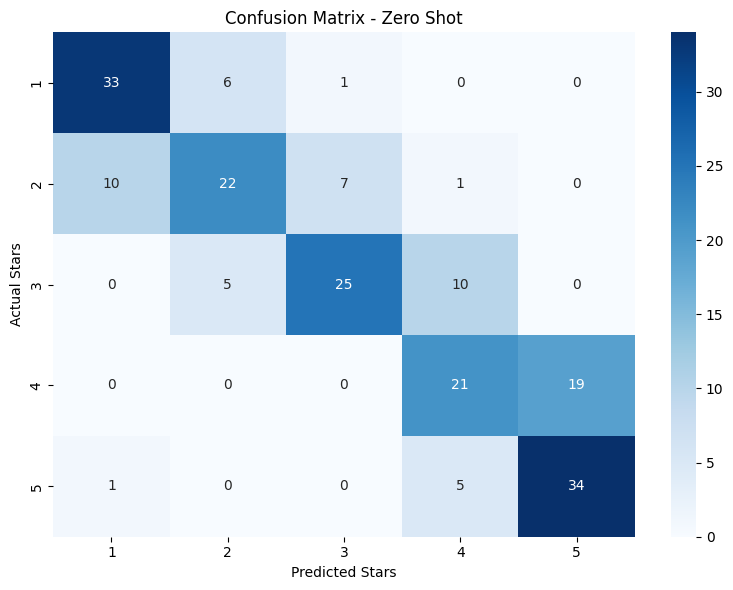


Total Errors: 65/200 (32.50%)

Error Breakdown:
-4     1
-1    20
 1    42
 2     2
Name: count, dtype: int64

Sample Errors (first 5):

  Actual: 5 | Predicted: 1
  Review: Tried going there for my 1st visit and they were closed during hours they were supposed to be open. ...
  Explanation: The customer was unable to visit or contact the business during posted hours, resulting in a completely failed service experience.

  Actual: 5 | Predicted: 4
  Review: I found some great t-shirts for friends here, including one from a local PHX artist with a grinning ...
  Explanation: The reviewer expresses clear satisfaction with the unique product selection and the store's atmosphere, recommending it as a great place for gifts.

  Actual: 5 | Predicted: 4
  Review: I violated my rule of avoiding grocery shopping while hungry and decided to venture over to Whole Fo...
  Explanation: The reviewer is highly enthusiastic about the food quality and variety, though they note the high prices and the 

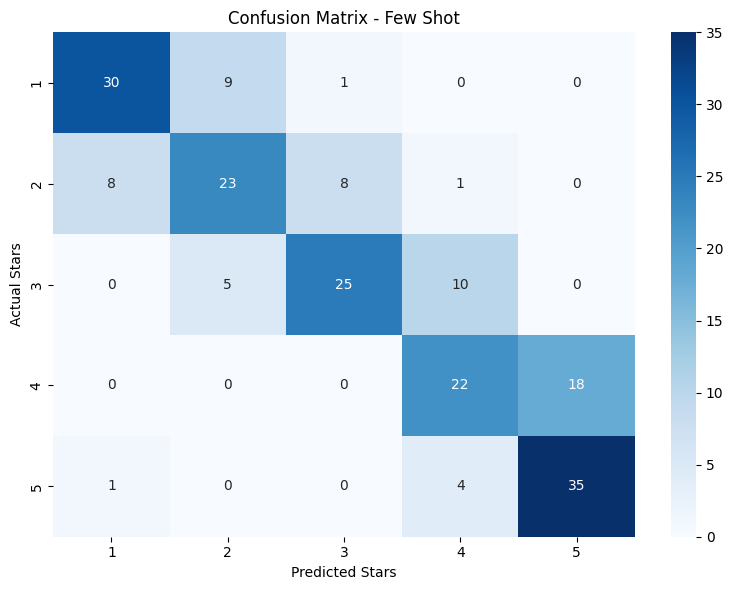


Total Errors: 65/200 (32.50%)

Error Breakdown:
-4     1
-1    17
 1    45
 2     2
Name: count, dtype: int64

Sample Errors (first 5):

  Actual: 5 | Predicted: 1
  Review: Tried going there for my 1st visit and they were closed during hours they were supposed to be open. ...
  Explanation: The reviewer had a very negative experience because the business was closed during posted hours and unresponsive to calls, preventing them from visiting at all.

  Actual: 5 | Predicted: 4
  Review: I found some great t-shirts for friends here, including one from a local PHX artist with a grinning ...
  Explanation: The reviewer expresses satisfaction with their purchase, recommends the store for its specific niche, and provides positive feedback on the atmosphere.

  Actual: 5 | Predicted: 4
  Review: Love chickafila :) they're pretty pricey for fast food though...
  Explanation: The reviewer expresses a strong positive sentiment by saying they love the brand, but includes a minor reservation reg

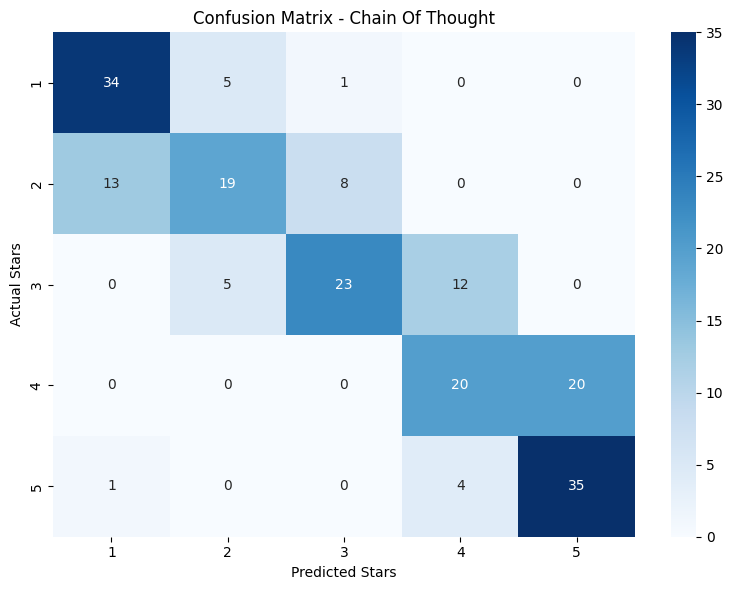


Total Errors: 69/200 (34.50%)

Error Breakdown:
-4     1
-1    22
 1    45
 2     1
Name: count, dtype: int64

Sample Errors (first 5):

  Actual: 5 | Predicted: 1
  Review: Tried going there for my 1st visit and they were closed during hours they were supposed to be open. ...
  Explanation: The review is entirely negative, focusing on the business being closed during stated hours and failing to answer the phone. Since the reviewer was unable to even access the service after multiple attempts, it represents a total failure of business operations, typically resulting in a 1-star rating.

  Actual: 5 | Predicted: 4
  Review: I found some great t-shirts for friends here, including one from a local PHX artist with a grinning ...
  Explanation: The review is overall positive, with the reviewer finding 'great' products and recommending the shop as the 'place to go' for gifts. There are no complaints or negative aspects mentioned, and the tone is satisfied and observational. It qualifies as 

In [ ]:
def analyze_predictions(results_df, approach_name):
    # Filter valid predictions
    valid = results_df[results_df['predicted_stars'].notna()].copy()
    
    if len(valid) == 0:
        print(f"⚠️ No valid predictions for {approach_name}")
        return
    
    print(f"\n{'='*80}")
    print(f"DETAILED ANALYSIS: {approach_name}")
    print(f"{'='*80}\n")
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(
        valid['actual_stars'], 
        valid['predicted_stars'],
        labels=[1, 2, 3, 4, 5],
        zero_division=0
    ))
    
    # Confusion Matrix
    cm = confusion_matrix(
        valid['actual_stars'], 
        valid['predicted_stars'],
        labels=[1, 2, 3, 4, 5]
    )
    
    # Visualize Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
    plt.title(f'Confusion Matrix - {approach_name}')
    plt.ylabel('Actual Stars')
    plt.xlabel('Predicted Stars')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{approach_name.replace(" ", "_").replace(":", "")}.png', dpi=300)
    plt.show()
    
    # Error Analysis
    errors = valid[valid['actual_stars'] != valid['predicted_stars']]
    print(f"\nTotal Errors: {len(errors)}/{len(valid)} ({len(errors)/len(valid)*100:.2f}%)")
    
    if len(errors) > 0:
        print("\nError Breakdown:")
        error_diff = (errors['predicted_stars'] - errors['actual_stars']).value_counts().sort_index()
        print(error_diff)
        
        print("\nSample Errors (first 5):")
        for idx, row in errors.head().iterrows():
            print(f"\n  Actual: {row['actual_stars']} | Predicted: {row['predicted_stars']}")
            print(f"  Review: {row['review_text']}")
            print(f"  Explanation: {row['explanation']}")

# Analyze each approach
for name, results in all_results.items():
    analyze_predictions(results, name.replace('_', ' ').title())

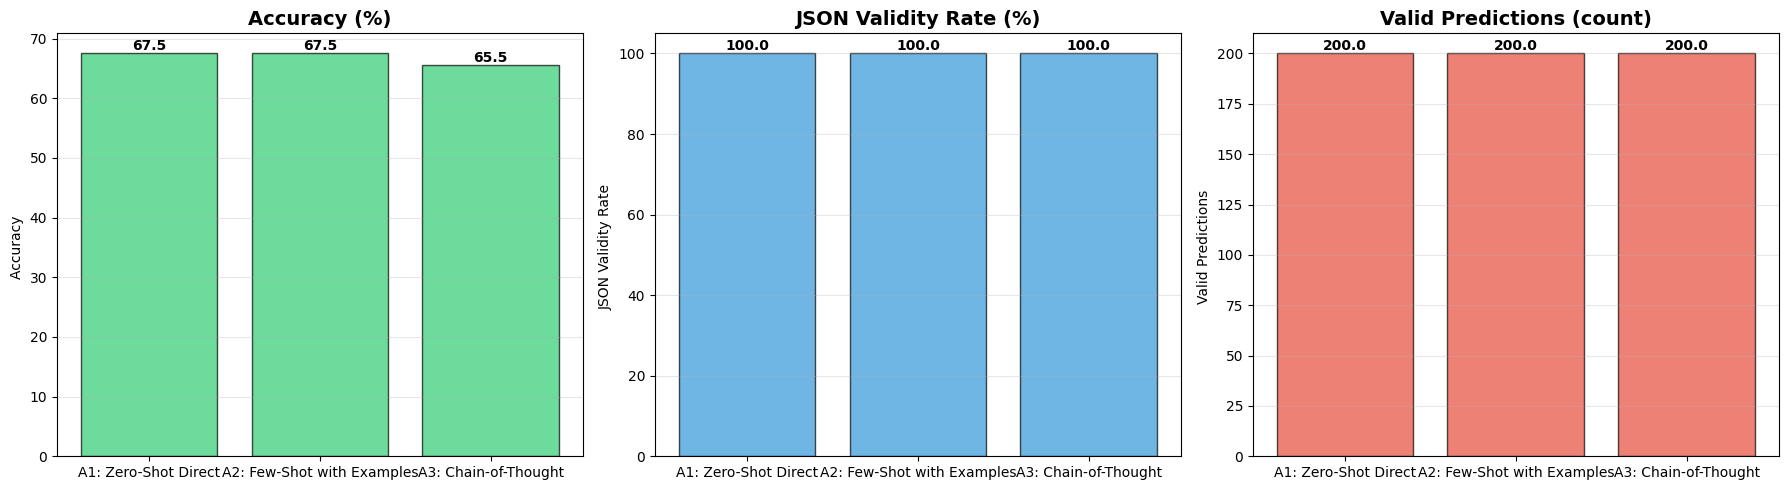

Visualization saved!


In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = ['accuracy', 'json_validity', 'valid_predictions']
titles = ['Accuracy (%)', 'JSON Validity Rate (%)', 'Valid Predictions (count)']
colors = ['#2ecc71', '#3498db', '#e74c3c']

for idx, (metric, title, color) in enumerate(zip(metrics_to_plot, titles, colors)):
    ax = axes[idx]
    values = [m[metric] for m in all_metrics]
    approaches = [m['approach'].replace('Approach ', 'A') for m in all_metrics]
    
    bars = ax.bar(approaches, values, color=color, alpha=0.7, edgecolor='black')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel(title.split('(')[0])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('approach_comparison_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved!")

In [16]:
def show_best_worst_predictions(results_df, approach_name, n=5):
    """
    Show best and worst predictions for qualitative analysis
    """
    valid = results_df[results_df['predicted_stars'].notna()].copy()
    
    # Calculate absolute error
    valid['error'] = abs(valid['actual_stars'] - valid['predicted_stars'])
    
    print(f"\n{'='*80}")
    print(f"BEST PREDICTIONS - {approach_name}")
    print(f"{'='*80}")
    
    best = valid[valid['error'] == 0].head(n)
    for idx, row in best.iterrows():
        print(f"\n✅ Perfect Match: {row['actual_stars']}")
        print(f"   Review: {row['review_text']}")
        print(f"   Explanation: {row['explanation']}")
    
    print(f"\n{'='*80}")
    print(f"WORST PREDICTIONS - {approach_name}")
    print(f"{'='*80}")
    
    worst = valid.nlargest(n, 'error')
    for idx, row in worst.iterrows():
        print(f"\nError: {int(row['error'])} stars (Actual: {row['actual_stars']}, Predicted: {row['predicted_stars']})")
        print(f"   Review: {row['review_text']}")
        print(f"   Explanation: {row['explanation']}")

# Show for each approach
for name, results in all_results.items():
    show_best_worst_predictions(results, name.replace('_', ' ').title(), n=3)


BEST PREDICTIONS - Zero Shot

✅ Perfect Match: 5
   Review: I never write these things. But I have to say that you will not be disappointed with Paletas Betty. ...
   Explanation: The reviewer uses superlative language such as 'highly recommend' and 'served in heaven,' indicating complete satisfaction with the product.

✅ Perfect Match: 5
   Review: I will continue to give this place five stars for so many reasons.  First, the menu is very creative...
   Explanation: The reviewer explicitly states they are giving the place five stars and provides high praise for the creative menu, food quality, and overall dining experience.

✅ Perfect Match: 5
   Review: I love to come here from time to time when I'm in the area and I am always highly satisfied with the...
   Explanation: The reviewer expresses consistent high satisfaction with the food, service, and atmosphere, explicitly recommending the restaurant as a great place to eat.

WORST PREDICTIONS - Zero Shot

Error: 4 stars (Actual: 5, 

In [18]:
print("\n" + "="*80)
print("FINAL SUMMARY & INSIGHTS")
print("="*80)

# Find best approach
best_accuracy = max(all_metrics, key=lambda x: x['accuracy'])
best_json = max(all_metrics, key=lambda x: x['json_validity'])

print(f"\nBest Accuracy: {best_accuracy['approach']} ({best_accuracy['accuracy']:.2f}%)")
print(f"Best JSON Validity: {best_json['approach']} ({best_json['json_validity']:.2f}%)")

print("\nKey Findings:")
print("-" * 80)

for metric in all_metrics:
    print(f"\n{metric['approach']}:")
    print(f"  • Accuracy: {metric['accuracy']:.2f}%")
    print(f"  • JSON Validity: {metric['json_validity']:.2f}%")
    print(f"  • Valid Predictions: {metric['valid_predictions']}/{metric['total_samples']}")
    print(f"  • API Failures: {metric['api_failures']}")

print("\n" + "="*80)

# Calculate average metrics
avg_accuracy = np.mean([m['accuracy'] for m in all_metrics])
avg_json_validity = np.mean([m['json_validity'] for m in all_metrics])

print(f"\nOverall Averages:")
print(f"  • Average Accuracy: {avg_accuracy:.2f}%")
print(f"  • Average JSON Validity: {avg_json_validity:.2f}%")

print("\nRecommendations:")
if best_accuracy['approach'] == best_json['approach']:
    print(f"  {best_accuracy['approach']} is the clear winner for both metrics")
else:
    print(f"  Trade-off: {best_accuracy['approach']} for accuracy")
    print(f"              {best_json['approach']} for JSON reliability")

print("\n" + "="*80)


FINAL SUMMARY & INSIGHTS

Best Accuracy: Approach 1: Zero-Shot Direct (67.50%)
Best JSON Validity: Approach 1: Zero-Shot Direct (100.00%)

Key Findings:
--------------------------------------------------------------------------------

Approach 1: Zero-Shot Direct:
  • Accuracy: 67.50%
  • JSON Validity: 100.00%
  • Valid Predictions: 200/200
  • API Failures: 0

Approach 2: Few-Shot with Examples:
  • Accuracy: 67.50%
  • JSON Validity: 100.00%
  • Valid Predictions: 200/200
  • API Failures: 0

Approach 3: Chain-of-Thought:
  • Accuracy: 65.50%
  • JSON Validity: 100.00%
  • Valid Predictions: 200/200
  • API Failures: 0


Overall Averages:
  • Average Accuracy: 66.83%
  • Average JSON Validity: 100.00%

Recommendations:
  Approach 1: Zero-Shot Direct is the clear winner for both metrics

